In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from bokeh.plotting import figure, output_file, show, output_notebook
from bokeh.models import Span
from shapely.geometry import Point
import geopandas as gpd
import glob
from datetime import datetime
from bokeh.layouts import Row, column, gridplot
from bokeh.models import Title, Legend, TapTool, Range1d, Tabs, Panel
import matplotlib as mpl
from bokeh.core.validation import silence
from bokeh.core.validation.warnings import MISSING_RENDERERS, EMPTY_LAYOUT

# Set fonts for matplotlib
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 14

In [2]:
import bokeh
from bokeh.core.validation.warnings import EMPTY_LAYOUT
bokeh.core.validation.silence(EMPTY_LAYOUT, True)
bokeh.core.validation.silence(EMPTY_LAYOUT, True)

{Warning(code=1002, name='EMPTY_LAYOUT', description='Layout has no children')}

In [3]:
def convert_to_gdf(df):
    print(df.columns)
    if 'geometry' in df.columns:
        gdf = gpd.GeoDataFrame(df, crs="EPSG:4326", geometry='geometry')
    else: 
        geometry = [Point(xy) for xy in zip(df.longitude, df.latitude)]
        gdf = gpd.GeoDataFrame(df, crs="EPSG:4326", geometry=geometry)

    return gdf

# Analysing business activity trends in Morocco

[Business Activity Trends](https://dataforgood.facebook.com/dfg/tools/business-activity-trends#methodology) are a crisis-triggered dataset released by Meta. The dataset is relesed at a GADM admin 2 level. [GADM shapefiles](https://gadm.org/) are slightly different from the official shapefiles used in this project from [HdX, UNOCHA](https://data.humdata.org/dataset/cod-ab-tur). One Business Activity Trends datasets is used in this analysis - Morocco Earthquake triggered dataset. 

This notebook shows the implementation of 

* Visualizing changes in trends in Business Actviity after the earthquake by admin region and business vertical

In [4]:
morocco_adm2 = gpd.read_file('../../data/shapefiles/gadm41_MAR_shp/gadm41_MAR_2.shp')
morocco_adm1 = gpd.read_file('../../data/shapefiles/gadm41_MAR_shp/gadm41_MAR_1.shp')

## Earthquake triggered business activity dataset

The Earthquake triggered Business Activity Trends dataset contains daily data from 12th September, 2023. This is done at the [GADM 2](https://gadm.org/) level. The activity quantile metric is used to measure changes in Business Activity. 

**Activity quantile (activity_quantile)**: The level of activity as a quantile relative to the baseline period. This is equivalent to the 7-day average of what the University of Bristol researchers call the aggregated probability integral transform metric (see this article in Nature Communications). It’s calculated by first computing the approximate quantiles (the midquantiles in the article) of each Page’s daily activity relative to their baseline activity. The quantiles are summed and the sum is then shifted, rescaled and variance-adjusted to follow a standard normal distribution. The adjusted sum is then probability transformed through a standard normal cumulative distribution function to get a value between 0 and 1. We then average this value over the last 7 days to smooth out daily fluctuations. We give this metric a quantile interpretation since it compares the daily activity to the distribution of daily activity within the baseline period, where **a value around 0.5 is considered normal activity**. This is a one-vote-per-Page metric that gives equal weight to all businesses and is not heavily influenced by businesses that post a lot. It is adviced to use this metric, especially if robustness to outliers and numerical stability are important concerns.

In [5]:
# define color palette
color_palette = [  '#4E79A7',  # Blue
    '#F28E2B',  # Orange
    '#E15759',  # Red
    '#76B7B2',  # Teal
    '#59A14F',  # Green
    '#EDC948',  # Yellow
    '#B07AA1',  # Purple
    '#FF9DA7',  # Pink
    '#9C755F',  # Brown
    '#BAB0AC',  # Gray
    '#7C7C7C',  # Dark gray
    '#6B4C9A',  # Violet
    '#D55E00',  # Orange-red
    '#CC61B0',  # Magenta
    '#0072B2',  # Bright blue
    '#329262',  # Peacock green
    '#9E5B5A',  # Brick red
    '#636363',  # Medium gray
    '#CD9C00',  # Gold
    '#5D69B1',  # Medium blue
]

In [6]:
bokeh.core.validation.silence(EMPTY_LAYOUT, True)

def get_line_plot(businessActivity,title, source, earthquakes=True, subtitle=None):

    p2 = figure(x_axis_type = 'datetime', width = 800, height = 400, toolbar_location='above')
    p2.add_layout(Legend(), "right")

    for id, business_vertical in enumerate(businessActivity['business_vertical'].unique()):

        df1 = businessActivity[businessActivity['business_vertical']==business_vertical][['ds', 'activity_quantile']].reset_index(drop=True)

        p2.line(df1['ds'], df1['activity_quantile'], line_width=2, line_color = color_palette[id], legend_label=business_vertical)

    p2.legend.click_policy='hide'
    if subtitle is not None:
        p2.title = subtitle


    title_fig = figure(title=title, toolbar_location=None,width=800, height=40, )
    title_fig.title.align = "left"
    title_fig.title.text_font_size = "12pt"
    title_fig.border_fill_alpha = 0
    title_fig.outline_line_width=0

    #with silence(MISSING_RENDERERS):
    sub_title = figure(title=source, toolbar_location=None,width=800, height=40, )
    sub_title.title.align = "left"
    sub_title.title.text_font_size = "10pt"
    sub_title.title.text_font_style="normal"
    sub_title.border_fill_alpha = 0
    sub_title.outline_line_width=0

    layout = column(title_fig, p2, sub_title)

    # if earthquakes:
    #     p2.renderers.extend([
    #     Span(
    #         location=datetime(2023, 9, 8),
    #         dimension="height",
    #         line_color='#7C7C7C',
    #         line_width=2,
    #         line_dash=(4,4)
    #   )
#         # Span(
#         #     location=datetime(2023, 2, 20),
#         #     dimension="height",
#         #     line_color='#7C7C7C',
#         #     line_width=2,
#         #     line_dash=(4,4)
#         # ),
#      ]
#  )

    return layout



In [14]:
# Get all datasets for earthquake-triggered business activity trends
businessActivity2023 = pd.read_csv('../../data/business_activity_trends/Data for Good at Meta - Business Activity Trends for Morocco - 2023-10-19.csv')


In [15]:
# convert columns to datetime
businessActivity2023['ds'] = businessActivity2023['ds'].apply(lambda x: pd.to_datetime(x))

In [16]:
print(f'Business Activity Trends has {len(businessActivity2023["polygon_name"].unique())} districts and the boundaries map from GADM contains {len(morocco_adm2["NAME_2"].unique())} districts. {len(morocco_adm2["NAME_2"].unique())-len(businessActivity2023["polygon_name"].unique())} districts do not have data')

Business Activity Trends has 50 districts and the boundaries map from GADM contains 54 districts. 4 districts do not have data


In [17]:
# Convert polygon name to lower to match with boundaries file and change column name
import unicodedata

businessActivity2023['polygon_name'] = businessActivity2023['polygon_name'].apply(lambda x: x.lower())
businessActivity2023['polygon_name'] = businessActivity2023['polygon_name'].apply(lambda x: unicodedata.normalize('NFD', x).encode('ascii', 'ignore').decode('utf-8'))

morocco_adm2['NAME_2_clean'] = morocco_adm2['NAME_2'].apply(lambda x: x.lower())
morocco_adm2['NAME_2_clean'] = morocco_adm2['NAME_2_clean'].apply(lambda x: unicodedata.normalize('NFD', x).encode('ascii', 'ignore').decode('utf-8'))


matched_districts = list(set(businessActivity2023['polygon_name'].unique()).intersection(set(morocco_adm2["NAME_2_clean"].unique())))
print(list(businessActivity2023[~(businessActivity2023["polygon_name"].isin(matched_districts))]['polygon_name'].unique()))
print('All districts are mapped to a corresponding shape')

[]
All districts are mapped to a corresponding shape


In [18]:
businessActivity2023 = businessActivity2023.merge(morocco_adm2[['NAME_1', 'NAME_2', 'geometry', 'NAME_2_clean']], left_on = 'polygon_name', right_on = 'NAME_2_clean')

gdf = convert_to_gdf(businessActivity2023)

Index(['crisis_fbid', 'crisis_day_number', 'polygon_id', 'polygon_name',
       'business_vertical', 'pages_count', 'activity_quantile', 'metrics_7d',
       'midquantile_sum_sd', 'ds', 'day', 'NAME_1', 'NAME_2', 'geometry',
       'NAME_2_clean'],
      dtype='object')


In [19]:
# Read earthquake file
mi_sep8 = gpd.read_file('../../data/earthquake/shape/mi.shp')

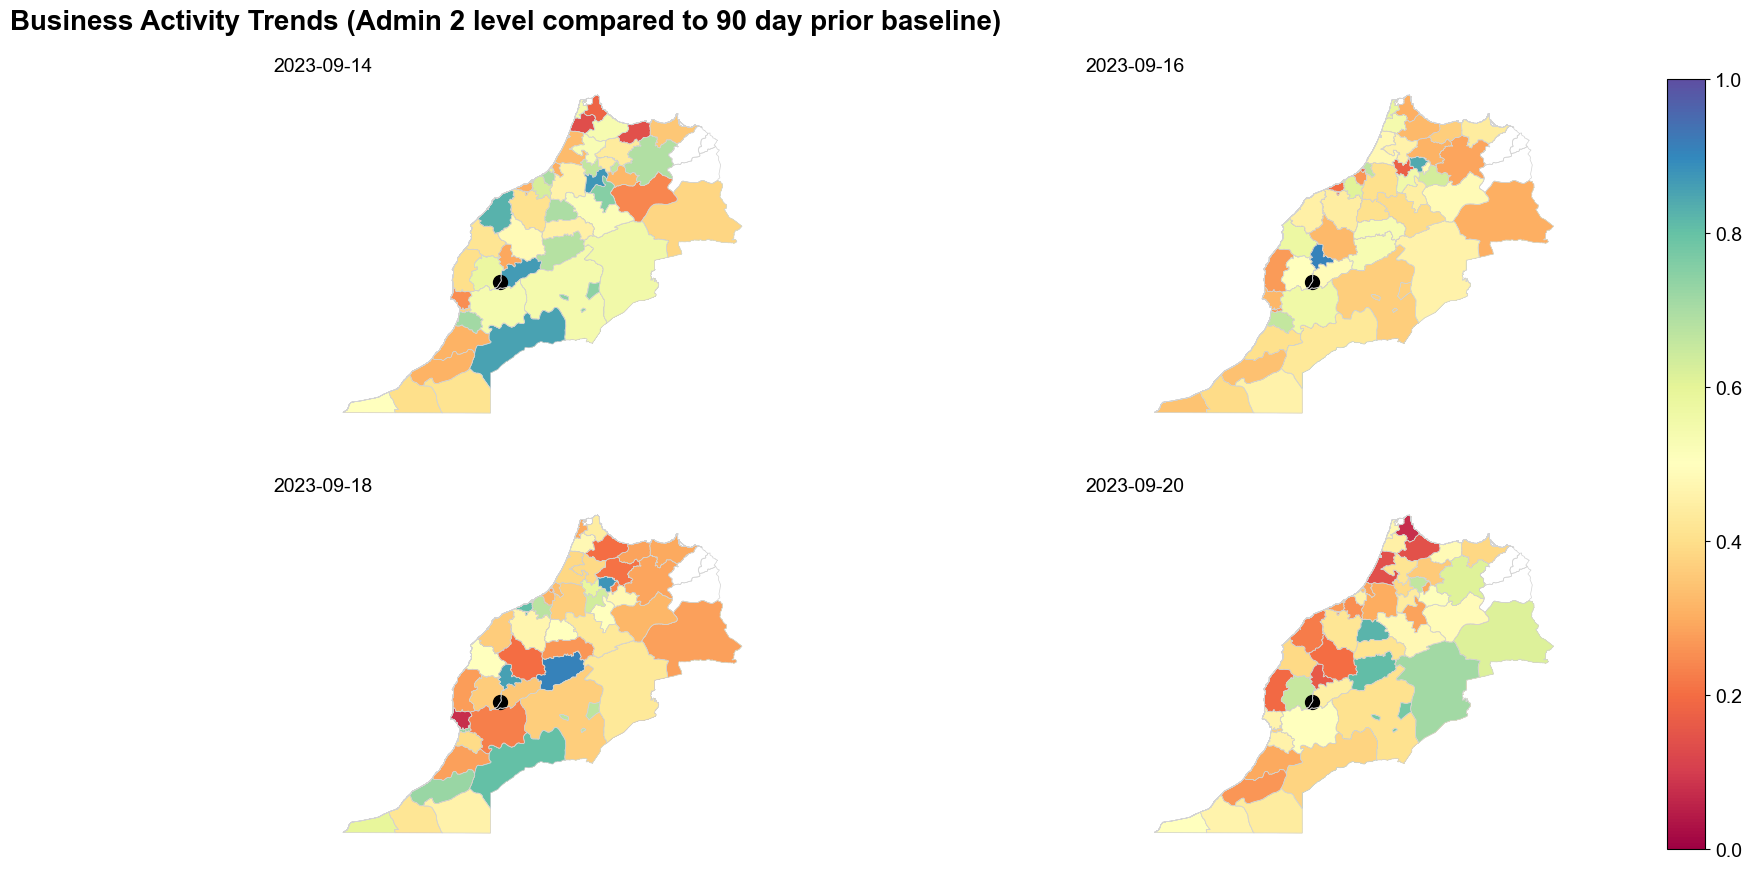

In [20]:
fig, axs = plt.subplots(2,2,figsize = (24,10), sharex=True, sharey=True)
ax = axs.flatten()


dates_of_interest = ['2023-09-14', '2023-09-16', '2023-09-18', '2023-09-20']
images = []

for i in range(0, len(dates_of_interest)):
    morocco_adm2.boundary.plot(ax=ax[i], edgecolor = '#D3D3D3', linewidth=0.5)
    im=gdf[gdf['ds']==dates_of_interest[i]][['activity_quantile', 'geometry']].plot(column = 'activity_quantile', ax=ax[i], legend = False, cmap = 'Spectral', vmin=0, vmax =1)
    images.append(im.collections[0])
    ax[i].set_title(f'{dates_of_interest[i]}', fontsize = 14, )
    ax[i].title.set_position([0,0])

    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['bottom'].set_visible(False)
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['left'].set_visible(False)

    ax[i].scatter(-8.3815,31.07, c='black', marker='o', s=100)

cbar = fig.colorbar(images[1], ax=axs)
suptitle= fig.suptitle('Business Activity Trends (Admin 2 level compared to 90 day prior baseline)', fontsize = 20, fontweight = 'bold')
suptitle.set_y(0.95)
suptitle.set_x(0.3)
#ax[0].cax = cbar.ax[0]

for im in images:
    im.set_clim(vmin=0, vmax=1)
    im.set_cmap('Spectral')
    im.set_norm(cbar.norm)

In [21]:
businessActivity2023['country'] = 'Morocco'

In [22]:
output_notebook()
bokeh.core.validation.silence(EMPTY_LAYOUT, True)
bokeh.core.validation.silence(MISSING_RENDERERS, True)

tabs = []

# Taking the mean activity quantile for the entire country to allow for comparison with last year's data
df = businessActivity2023.groupby(['country', 'business_vertical', 'ds']).mean('activity_quantile').reset_index()

tabs.append(Panel(child=get_line_plot(df, f"Business Activity in 2023", "Source: Data for Good Meta", earthquakes=True, subtitle = 'National average post earthquake compared to 90 day prior baseline')
                  ,title = 'National Average'))

tabs = Tabs(tabs=tabs, sizing_mode="scale_both")
show(tabs, warn_on_missing_glyphs=False)

Loading BokehJS ...

### Marrackech - Tensfit - Al Haouz had the most impact

Within this admin region, it can be seen that the sector most impacted are Home Services, Manufacturing, Local Events, Professional Services, Public Good and Travel. 

In [23]:
output_notebook()
bokeh.core.validation.silence(EMPTY_LAYOUT, True)
bokeh.core.validation.silence(MISSING_RENDERERS, True)


tabs = []

for adm in morocco_adm1['NAME_1'].unique():
    df = businessActivity2023[businessActivity2023['NAME_1']==adm] 
    df = df.groupby(['NAME_1', 'business_vertical', 'ds']).mean('activity_quantile').reset_index()

    tabs.append(
        Panel(
        child=get_line_plot(df, f"Business Activity in Affected Areas", "Source: Data for Good Meta", earthquakes=True, subtitle = 'GADM2 level average post earthquake compared to 90 day prior baseline'),
                    title=adm.capitalize(),
                )
                )

tabs = Tabs(tabs=tabs, sizing_mode="scale_both")
show(tabs, warn_on_missing_glyphs=False)

Loading BokehJS ...

## Change in Business Activity by business verticals in Marrakech - Tensfit - Al Haouz

One of the most impacted areas is the Marrackech - tensfit - al houz region. Examining the admin 2 regions within this region would paint a picture on the sub regions with high impact

In [24]:
output_notebook()
bokeh.core.validation.silence(EMPTY_LAYOUT, True)
bokeh.core.validation.silence(MISSING_RENDERERS, True)


tabs = []

for adm in morocco_adm2[morocco_adm2['NAME_1']=='Marrakech - Tensift - Al Haouz']['NAME_2'].unique():
    df = businessActivity2023[businessActivity2023['NAME_2']==adm] 
    df = df.groupby(['NAME_2', 'business_vertical', 'ds']).mean('activity_quantile').reset_index()

    tabs.append(
        Panel(
        child=get_line_plot(df, f"Business Activity in Affected Areas", "Source: Data for Good Meta", earthquakes=True, subtitle = 'GADM2 level average post earthquake compared to 90 day prior baseline'),
                    title=adm.capitalize(),
                )
                )

tabs = Tabs(tabs=tabs, sizing_mode="scale_both")
show(tabs, warn_on_missing_glyphs=False)

Loading BokehJS ...

: 